In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

## Подготовка urls_train

In [3]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['id', 'url', 'count']
urls_train_df = urls_train_df[['id', 'url']]

urls_train_df.head()

,id,url
0,000000014B60815F65B38258011B6C01,login.rutracker.org
1,000000014B60815F65B38258011B6C01,rutracker.org
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net
3,000000014C03DA2A47AC433A0C755201,czinfo.ru
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru


In [4]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_train_df['id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'id']
urls_train_df.head()

,urls,id
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01


In [5]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


In [7]:
train_df = urls_train_df.merge(age_train_df, on='id', how='left')
train_df.head()

,urls,id,age
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101,53
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801,48
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901,28
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901,44
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01,48


## Подготовка urls_test

In [9]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['id', 'url', 'count']
urls_test_df = urls_test_df[['id', 'url']]

urls_test_df.head()

,id,url
0,0000000151004FF4ADD746DA10685A01,afisha.ru
1,0000000151004FF4ADD746DA10685A01,aif.ru
2,0000000151004FF4ADD746DA10685A01,aimfar.solution.weborama.fr
3,0000000151004FF4ADD746DA10685A01,alkotest.ru
4,0000000151004FF4ADD746DA10685A01,aptekamos.ru


In [10]:
urls_test_df = pd.DataFrame(urls_test_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_test_df['id'] = urls_test_df.index
urls_test_df.index = range(len(urls_test_df))
urls_test_df.columns = ['urls', 'id']
urls_test_df.head()

,urls,id
0,"[1000bankov.ru, 1tv.ru, 4put.ru, argumenti.ru,...",000000014A02348E701552980349FF01
1,"[autorambler.ru, bilettorg.ru, dsol-druzhba.ru...",000000014A10EA183BF8594A0B2AB201
2,"[photosight.ru, rambler.ru]",000000014A4FE5C33A929D4C26943601
3,"[base.consultant.ru, dogovor-obrazets.ru, fd.r...",000000014B7BB9957784A9BC0AC9F401
4,"[assessor.ru, audit-it.ru, base.garant.ru, com...",000000014C7749F896D82C2B01E8B801


## Снижение размерности

In [15]:
topk = 300000
X, y = train_df.urls.values[:topk], train_df.age.values[:topk]

['id.rambler.ru', 'mail.rambler.ru', 'r0.ru']
53


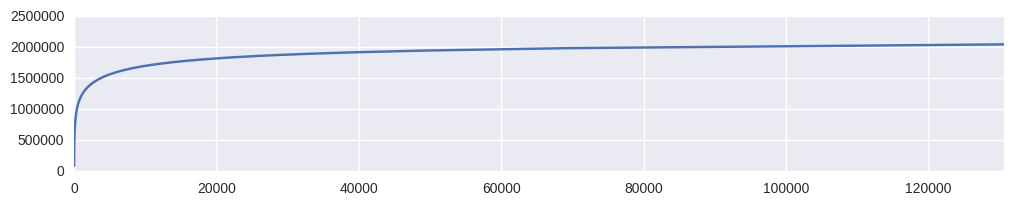

In [16]:
print X[0]
print y[0]
url_frequency = pd.Series([j for i in X for j in i]).value_counts()
url_frequency.index = range(len(url_frequency))

url_frequency.cumsum().plot(figsize=(12,2))

In [17]:
X = map(lambda x: ' '.join(x), X)
hw = HashingVectorizer(n_features=1000, non_negative=True).fit(X)
X = hw.transform(X).todense()


In [18]:
X.shape

(118603, 1000)